# Discovering insights from VP Duterte speeches

## Setup the environment


In [1]:
# Packages for data manipulation
from collections import Counter
import pandas as pd
import spacy

# Packages for visualization
import matplotlib.pyplot as plt
import matplotlib.image as img
from wordcloud import WordCloud

C:\Users\rmape\AppData\Local\Temp\ipykernel_14708\3617050776.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
en_nlp = spacy.load("en_core_web_md")

## Dataset preparation

In [3]:
df = pd.read_csv("data/speeches.csv")
df.head()

,title,link,date,content
0,ISO Recertification of the Office of the Vice ...,https://www.ovp.gov.ph/post/iso-recertificatio...,2024-01-15,Office of the Vice President Mandaluyong City ...
1,VPSD Speech on Go Negosyo's 18th anniversary,https://www.ovp.gov.ph/post/vpsd-speech-go-neg...,2023-11-27,Assalamualaikum… Madayaw ug maayong gabii kani...
2,VPSD Speech for National Children's Month Culm...,https://www.ovp.gov.ph/post/vpsd-speech-nation...,2023-11-27,"November 27, 2023, at 2:00 PM Ladies and gentl..."
3,VPSD Speech for the Gift-Giving in Binalonan,https://www.ovp.gov.ph/post/vpsd-speech-gift-g...,2023-11-25,"Gift-giving to 1,500 receipients Date of Event..."
4,VP Sara speech for the Renaming of Agham Road ...,https://www.ovp.gov.ph/post/vp-sara-speech-for...,2023-11-17,"Quezon City Mga Kababayan,Ladies and Gentlemen..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    54 non-null     object
 1   link     54 non-null     object
 2   date     54 non-null     object
 3   content  54 non-null     object
dtypes: object(4)
memory usage: 1.8+ KB


## Explorative Data Analysis

## What are the most common words in the speeches?

Step-by-step approach:

1. Tokenize the text using spaCy English model
2. Remove Filipino stopwords

In [5]:
en_tokens = []

for speech in df["content"]:
    doc = en_nlp(speech)
    tokens = [
        token.text.lower()
        for token in doc
        if not token.is_punct and not token.is_space and not token.is_stop
    ]
    en_tokens.extend(tokens)

In [6]:
Counter(en_tokens).most_common(5)

[('sa', 800), ('ang', 411), ('na', 403), ('education', 362), ('mga', 347)]

Tokenization using spaCy English model does not work well with Filipino text. So, we have to remmove the Filipino stopwords from the list of tokens.

In [7]:
with open("data/tl-stopwords.txt") as f:
    tl_stopwords = f.read().splitlines()

en_tokens = [token for token in en_tokens if token not in tl_stopwords]

In [8]:
Counter(en_tokens).most_common(5)

[('education', 362),
 ('learners', 163),
 ('school', 137),
 ('children', 137),
 ('people', 125)]

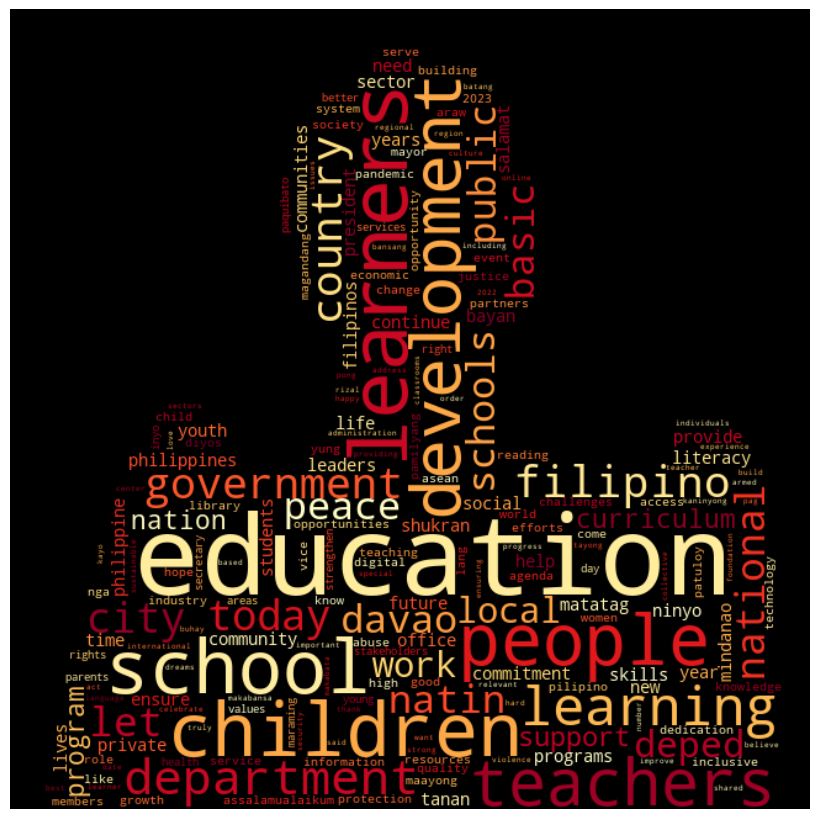

In [9]:
image = img.imread("data/mask.jpg")

wc = WordCloud(max_words=200, mask=image, colormap="YlOrRd_r")
wc = wc.generate_from_frequencies(Counter(en_tokens))

plt.figure(figsize=(8, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()